In [223]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Regression

This kernel builds a regression model for the Kaggle house price competition.

There are lots of great kernels already submitted that cover exploration and visualisation, so I will go light on that section and heavier on the data processing and modelling with the hope of getting a respectable score.

### Contents
1. [Data preprocessing](#preprocessing)
    1. [Accomodating nulls](#nulls)
    2. [Examining types](#types)
    3. [Encoding](#encoding)
    4. [Engineering](#engineering)
    5. [Outliers](#outliers)
    6. [Transformations](#transformations)
    7. [Scaling](#scaling)
2. [Model building](#modelling)
3. [Cross validation](#cv)

### Data preprocessing <a name="preprocessing"></a>

There is a fair whack to do here. Good mix of categorical, ordinal and continuous data with all three kinds stored as either numerical or string data. In addition, some of the columns are mostly null or lack variance as a result of being mostly zero, so there are a few decisions to make here that will have a large impact on later modelling performance.

First step though is to load the train and test data sets. Drop the ID column from the training set to align columns with the test set.

In [224]:
train_df = pd.read_csv('../input/train.csv')
train_df.drop('Id', inplace=True, axis=1)
test_df = pd.read_csv('../input/test.csv')
print('Train size:\t#rows = {}, #cols = {}\nTest size:\t#rows = {}, #cols = {}'.format(train_df.shape[0], train_df.shape[1],
                                                                                       test_df.shape[0], test_df.shape[1]))

Train size:	#rows = 1460, #cols = 80
Test size:	#rows = 1459, #cols = 80


Append the two sets for now to streamline the preprocessing steps and reduce error possibility.

In [225]:
train_df['train_set'] = 1
test_df['train_set'] = 0
df = train_df.append(test_df)
df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,train_set
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,0,Pave,8,856.0,AllPub,0,2003,2003,2008,1
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,0,Pave,6,1262.0,AllPub,298,1976,1976,2007,1
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,0,Pave,6,920.0,AllPub,0,2001,2002,2008,1
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,0,Pave,7,756.0,AllPub,0,1915,1970,2006,1
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,0,Pave,9,1145.0,AllPub,192,2000,2000,2008,1


#### Nulls <a name="nulls"></a>

So what do we have? A good first step with checking the quality of any data set is to look for nulls. Lets see which features in this set are affected.

In [226]:
cols_with_nulls, null_perc = [], []
for col in df.columns:
    if sum(df[col].isnull()) > 0:
        cols_with_nulls.append(col)
        null_perc.append(100 * sum(df[col].isnull()) / len(df))
null_counts = pd.DataFrame({'column': cols_with_nulls, 'null_perc': null_perc}).sort_values(by='null_perc',
                                                                                            ascending=False)

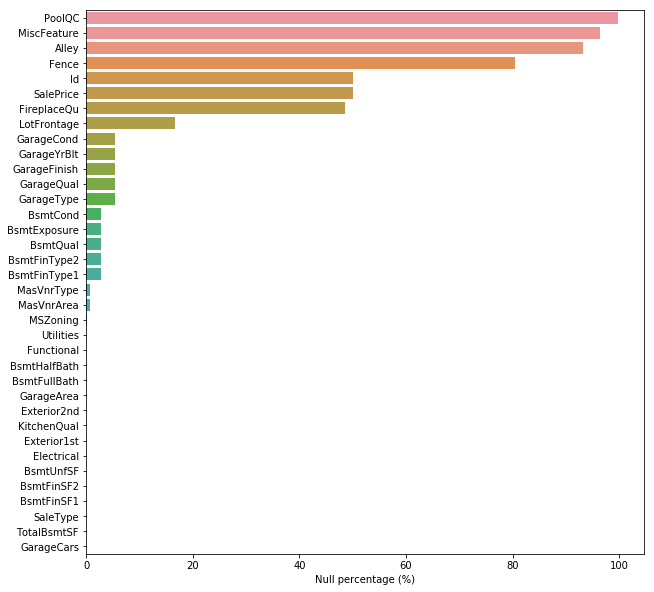

In [227]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
sns.barplot(x='null_perc', y='column', data=null_counts, ax=ax)
ax.set_xlabel('Null percentage (%)')
ax.set_ylabel('')
plt.show()

So in fairness, the majority of the features are OK. However, there are a handful of columns over 50% null. I will drop these as any machine learning algorithm will struggle to make use of them. Even algorithms like LightGBM that have native handling of nulls would probably ignore them due to a lack of variance.

In [228]:
null_threshold = .5
for col in df.columns:
    if (sum(df[col].isnull()) / len(df) > null_threshold) & (col != 'SalePrice'):  # Don't drop the target
        df.drop(col, axis=1, inplace=True)

#### Datatypes <a name="types"></a>

Next let's check the data *types*. A starting assumption I would make is that integer columns contain counts or ordinal data, floats contain continuous data and objects contain ordinal or categorical data as strings. 

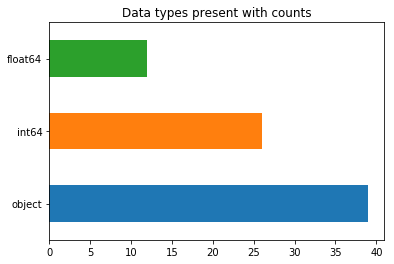

In [229]:
df.dtypes.value_counts().plot(kind='barh')
plt.title('Data types present with counts')
plt.show()

So those are the numpy datatypes, but I would like to group them by conceptual datatypes, i.e. continuous, ordinal and categorical, for further use in this kernel.

To start, I can look at the numerical values (those that are not dtype == object), with the presumption that most will be continuous or ordinal

In [230]:
numerical_cols = df.columns[df.dtypes != 'object'].tolist()
print(numerical_cols)

['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold', 'train_set']


So does this look right? As mentioned, a few, if not most, of these will be ordinal or possibly encoded categoricals. Fortunately, I don't have to infer this (using df.describe() for example) as Kaggle provides the answers in the data_description.txt file (some painstaking ctrl+c and +v'ing later...):

In [231]:
ordinal_numericals = ['BsmtFullBath', 'BsmtHalfBath', 'Fireplaces', 'FullBath', 'GarageCars', 
                      'HalfBath', 'MoSold', 'OverallCond', 'OverallQual', 'TotRmsAbvGrd']
date_numericals = ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd', 'YrSold']
boolean_numericals = ['BedroomAbvGr', 'KitchenAbvGr']
categorical_numericals = ['MSSubClass']

The remaining numericals are the continuous ones:

In [232]:
continuous_feats = [col for col in numerical_cols if col not in ordinal_numericals and\
                                                     col not in date_numericals and\
                                                     col not in boolean_numericals and\
                                                     col not in categorical_numericals]

In [233]:
df[continuous_feats].describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,GarageArea,GrLivArea,LotArea,...,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,PoolArea,SalePrice,ScreenPorch,TotalBsmtSF,WoodDeckSF,train_set
count,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2918.000000,2919.000000,2918.000000,2919.000000,2919.000000,...,2919.000000,2896.000000,2919.000000,2919.000000,2919.000000,1460.000000,2919.000000,2918.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,441.423235,49.582248,560.772104,23.098321,472.874572,1500.759849,10168.114080,...,4.694416,102.201312,50.825968,47.486811,2.251799,180921.195890,16.062350,1051.777587,93.709832,0.500171
std,392.362079,428.701456,25.188169,455.610826,169.205611,439.543659,64.244246,215.394815,506.051045,7886.996359,...,46.396825,179.334253,567.402211,67.575493,35.663946,79442.502883,56.184365,440.766258,126.526589,0.500086
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,1300.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,0.000000,0.000000,0.000000
25%,876.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,320.000000,1126.000000,7478.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,0.000000,793.000000,0.000000,0.000000
50%,1082.000000,0.000000,0.000000,368.500000,0.000000,467.000000,0.000000,480.000000,1444.000000,9453.000000,...,0.000000,0.000000,0.000000,26.000000,0.000000,163000.000000,0.000000,989.500000,0.000000,1.000000
75%,1387.500000,704.000000,0.000000,733.000000,0.000000,805.500000,0.000000,576.000000,1743.500000,11570.000000,...,0.000000,164.000000,0.000000,70.000000,0.000000,214000.000000,0.000000,1302.000000,168.000000,1.000000
max,5095.000000,2065.000000,508.000000,5644.000000,1526.000000,2336.000000,1012.000000,1488.000000,5642.000000,215245.000000,...,1064.000000,1600.000000,17000.000000,742.000000,800.000000,755000.000000,576.000000,6110.000000,1424.000000,1.000000


Similarly, I can expect the object dtypes to be non-numerical and therefore mostly categorical. However, from the data_description.txt document, a fair few of the non-numerical datatypes are ordinal. For example: 

BsmtQual: Evaluates the height of the basement
- Ex	Excellent (100+ inches)	
- Gd	Good (90-99 inches)
- TA	Typical (80-89 inches)
- Fa	Fair (70-79 inches)
- Po	Poor (<70 inches
- NA	No Basement
       
It would be a shame to lose this order by making BsmtQual purely categorical, so this may need some thought. In practice, this means only label encoding them in order rather that one-hot encoding. However, there are no guarantees label encoded ordinals will perform better that one-hot encoded categoricals, so I will probably CV to check.

Define them separately for now.

In [234]:
non_numerical_cols = df.columns[df.dtypes == 'object'].tolist()
print(non_numerical_cols)

['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']


In [235]:
categorical_strings = ['BldgType', 'Condition1', 'Condition2', 'Electrical', 'Exterior1st', 
                       'Exterior2nd', 'Foundation', 'GarageType', 'Heating', 'HouseStyle', 
                       'LandContour', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 
                       'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 'SaleCondition',
                       'SaleType', 'Street', 'Utilities']
ordinal_strings = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'ExterCond',
                  'ExterQual', 'FireplaceQu', 'Functional',  'GarageCond', 'GarageFinish', 'GarageQual',
                   'HeatingQC', 'KitchenQual', 'LandSlope']
boolean_strings = ['CentralAir']

Whilst I have the datatypes broken out, I will use this to inform a null-filling strategy:

- Continuous variables filled by median
- Ordinal values filled by the mode
- Categorical values filled with a null category ('NA')

In [236]:
all_categoricals = categorical_numericals + categorical_strings
df[all_categoricals].fillna('NA', inplace=True)

all_ordinals = ordinal_numericals + ordinal_strings
mode_df = pd.DataFrame(data=df[all_ordinals].mode().values.tolist()[0], index=all_ordinals)
df[all_ordinals].fillna(mode_df[0], inplace=True)

df[continuous_feats].fillna(df[continuous_feats].median(), inplace=True)

#### Encoding  <a name="encoding"></a>

So both my categorical and ordinal features need encoding. All categoricals need one-hot encoding. Non-numerical ordinals need at least label encoding (by painstakingly mapping their order to integers), whilst numerical ordinals *may* be fine as they are.

##### Categorical features

In [237]:
print('Shape before one-hot encoding of categoricals =\t{}'.format(df.shape))
df = pd.get_dummies(df, columns=all_categoricals)
print('Shape after one-hot encoding of categoricals =\t{}'.format(df.shape))

Shape before one-hot encoding of categoricals =	(2919, 77)
Shape after one-hot encoding of categoricals =	(2919, 236)


##### Ordinal features

Unfortunately, I will have to create dictionaries to map the non-numerical features to from the data_description.txt file.

In [238]:
ordinal_dict_1 = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
ordinal_dict_2 = {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
ordinal_dict_3 = {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
ordinal_dict_4 = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}
ordinal_dict_5 = {'Na': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
ordinal_dict_6 = {'Sev': 0, 'Mod': 1, 'Gtl': 2}

In [239]:
for cat in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
            'GarageQual', 'GarageCond', ]:
    df[cat] = df[cat].map(ordinal_dict_1)
    
for cat in ['BsmtExposure']:
    df[cat] = df[cat].map(ordinal_dict_2)
    
for cat in ['BsmtFinType1', 'BsmtFinType2']:
    df[cat] = df[cat].map(ordinal_dict_3)
    
for cat in ['Functional']:
    df[cat] = df[cat].map(ordinal_dict_4)
    
for cat in ['GarageFinish']:
    df[cat] = df[cat].map(ordinal_dict_5)
    
for cat in ['LandSlope']:
    df[cat] = df[cat].map(ordinal_dict_6)
    
# Check I haven't introduced more nulls
null_counts.set_index('column', inplace=True)
for col in ordinal_strings:
    if sum(df[col].isnull()) > 0:
        null_counts.loc[col, 'perc_after_encoding'] = 100 * sum(df[col].isnull()) / len(df)
        assert null_counts.loc[col, 'perc_after_encoding'] == null_counts.loc[col, 'null_perc'],\
        'Nulls introduced in feature {}, check corresponding dictionary'.format(col)

Boolean string variables just need label encoding

In [240]:
for cat in boolean_strings:
    encoder = LabelEncoder()
    df[cat] = encoder.fit_transform(df[cat])

So how does the data set look now after encoding?

In [241]:
df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,856,854,0,3,3.0,1.0,706.0,0.0,6.0,1.0,...,0,0,0,0,0,1,0,1,1,0
1,1262,0,0,3,3.0,4.0,978.0,0.0,5.0,1.0,...,0,0,0,0,0,1,0,1,1,0
2,920,866,0,3,3.0,2.0,486.0,0.0,6.0,1.0,...,0,0,0,0,0,1,0,1,1,0
3,961,756,0,3,4.0,1.0,216.0,0.0,5.0,1.0,...,0,0,0,0,0,1,0,1,1,0
4,1145,1053,0,4,3.0,3.0,655.0,0.0,6.0,1.0,...,0,0,0,0,0,1,0,1,1,0


#### Engineering <a name="engineering"></a>

Perhaps a loose definition of engineering, but in this section I'm looking to create new features from the existing ones. 

In [242]:
# Total prime living space - indoor, proper space
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF']

# Total 'sub-prime' living space - outdoors + basements etc.
df['AltTotalSF'] = df['TotalBsmtSF'] + df['ScreenPorch'] + df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch']\
                   + df['GarageArea'] + df['LowQualFinSF']

For the date variables, convert them to the difference in years between each feature and YrSold.

In [243]:
date_numericals.remove('YrSold')
for date_col in date_numericals:
    df[date_col] = df['YrSold'] - df[date_col]

# Create a Boolean of those properties that have had work done
df['RemodelledFlag'] = df['YearBuilt'] != df['YearRemodAdd']

#### Outliers <a name="outliers"></a>

This is a regression problem, so we want to check it there are any major outliers in the target variable. If we find some, which we probably will, it is best to delete them so the model doesn't overfit to them. This is essentially admitting a limitation of machine learning in that in can only learn the general case, and is by nature unable to predict outlying data that doesn't follow any trends.

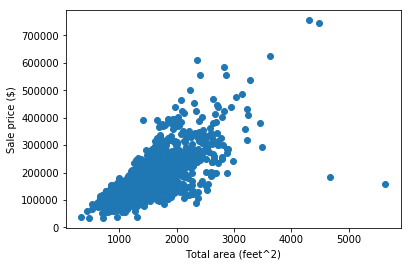

In [244]:
# Guess the most important feature just to break the data out:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.scatter(df['TotalSF'], df['SalePrice'])
ax.set_xlabel('Total area (feet^2)')
ax.set_ylabel('Sale price ($)')
plt.show()

So I would probably say there are 4 outliers here. There are two in the lower right that do not follow the trend at all, and there are two in the top right. These two seem to follow the linear relationship here, but they are so far away from the rest of the data that I worry they might be outliers with respect to other features. Off with their heads!

In [245]:
print('Shape before outlier removal:\t{}'.format(df.shape))
df = df[df['TotalSF'] < 4000]  # The outliers are basically just the massive houses
print('Shape after outlier removal:\t{}'.format(df.shape))

Shape before outlier removal:	(2919, 239)
Shape after outlier removal:	(2914, 239)


#### Transformations <a name="transformations"></a>

Here, I will be looking to correct the skew in the distribution of the continuous features including the target variable.

In [246]:
skew_array = skew(df[continuous_feats].fillna(df[continuous_feats].median()), axis=0)
skew_df = pd.DataFrame({'column': continuous_feats, 'skew': skew_array}).sort_values(by='skew', ascending=False)

Have a look at the worst ones. Seems like the biggest source of skew is having values that are mostly 0.

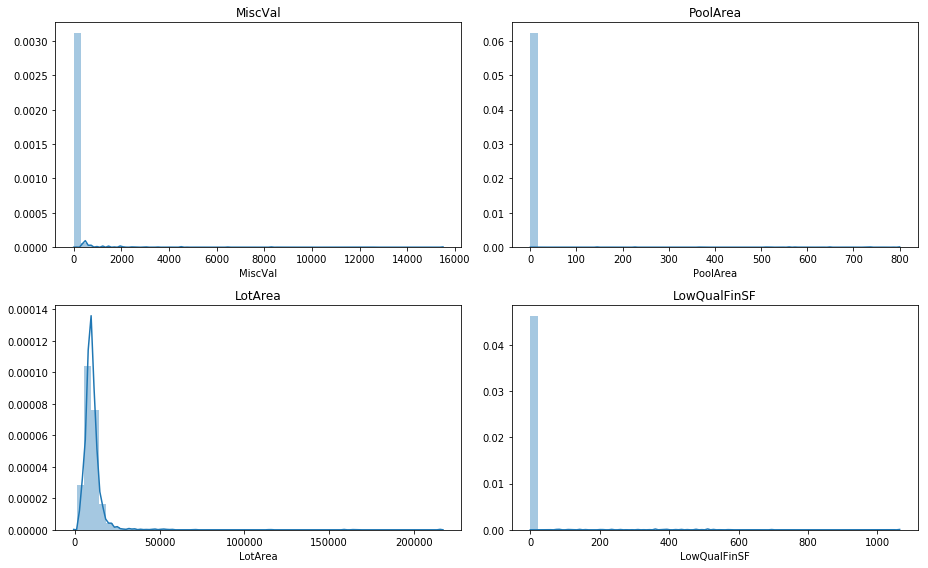

In [247]:
fig, axs = plt.subplots(2, 2, figsize=[13, 8])
i = 0
for ax in axs.ravel():
    sns.distplot(df[skew_df.iloc[i, 0]], ax=ax)
    ax.set_title(skew_df.iloc[i, 0])
    i += 1
plt.tight_layout()
plt.show()

In [248]:
df[continuous_feats] = np.log1p(df[continuous_feats].fillna(df[continuous_feats].median()))

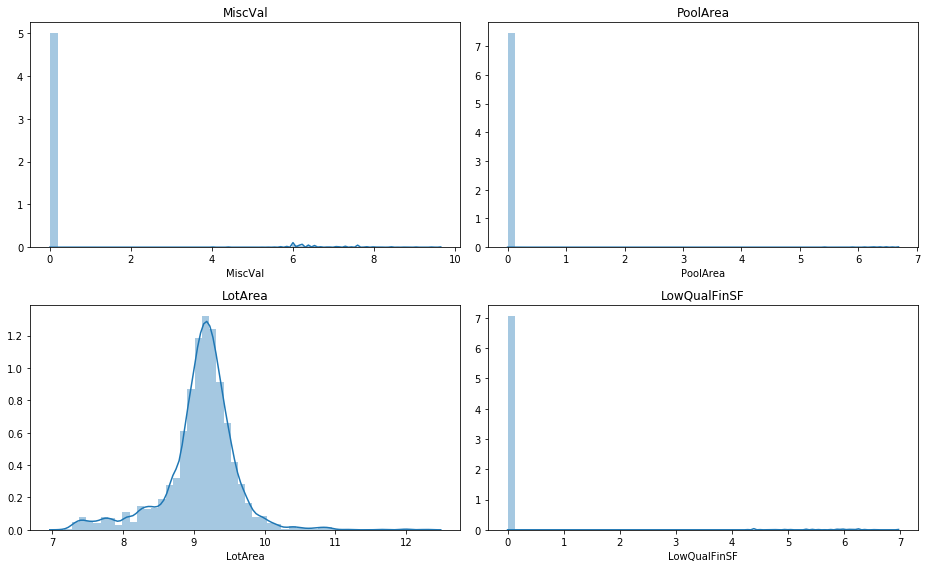

In [249]:
new_skew_array = skew(df[continuous_feats].fillna(df[continuous_feats].median()), axis=0)
new_skew_df = pd.DataFrame({'column': continuous_feats, 'skew': new_skew_array}).sort_values(by='skew', ascending=False)
fig, axs = plt.subplots(2, 2, figsize=[13, 8])
i = 0
for ax in axs.ravel():
    sns.distplot(df[skew_df.iloc[i, 0]], ax=ax)
    ax.set_title(skew_df.iloc[i, 0])
    i += 1
plt.tight_layout()
plt.show()

So log transformation doesn't fix the mostly zeros columns, but does help otherwise. This raises the issue of low-variance features - should they be dropped due to not providing rich information whilst increasing the dimensionality?

#### Scaling <a name="transformations"></a>

To give myself the option of using non-tree methods (e.g. linear models or neural nets), I want to scale my features such that they are all of the same magnitude. This will prevent any feature gaining inaccurate training weight just on account of it being big numbers.

To do so I will just use standard scaling: scale to a mean of 0 and standard deviation of 1. As per, sklearn has a tidy class for this.

In [250]:
y = df.pop('SalePrice')  # No point scaling the label really (although it wouldn't hurt
y = y[df['train_set'] == 1]

In [251]:
scaler = StandardScaler()
scaler.fit_transform(df[df.columns])

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').